In [82]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  
sys.path.insert(0, str(PROJECT_ROOT))

In [83]:
import pandas as pd 
from src.diagnostic import pre_stat, missingness_matrix, numerical_check
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import numpy as np
from sklearn.linear_model import LinearRegression





In [84]:

DATA_DIR=PROJECT_ROOT/'data'

df_baseline=pd.read_csv(DATA_DIR / 'raw' / 'MigraineBaselineVars.csv',sep=';')

df_longitudinal=pd.read_csv(DATA_DIR / 'raw'/ 'MigraineLongitudianlVars.csv',sep=';')
    


In [85]:
df_baseline.shape

(179, 35)

# baseline 

In [86]:
pre_stat(df_baseline)

,fraction_missing,count_missing,unique_value
SUBJECT_ID,0.000000,0,179
AGE,0.000000,0,51
SEX,0.000000,0,2
DIAGNOSIS,0.000000,0,3
Suspension,0.000000,0,2
MONTHS_OF_TREAT,0.000000,0,27
TREATMENT_DISC,0.000000,0,5
AGE_OF_ONSET,0.061453,11,32
AGE_W_CHRONICMIGRAINE,0.061453,11,39
FAMILIARITY,0.525140,94,2


In [87]:
df_baseline["Psycopathological"]

0      3.0
1      1.0
2      0.0
3      3.0
4      5.0
      ... 
174    NaN
175    NaN
176    NaN
177    NaN
178    NaN
Name: Psycopathological, Length: 179, dtype: float64

In [88]:
continuous_vars = [
    "AGE", "AGE_OF_ONSET", "AGE_W_CHRONICMIGRAINE",
    "WEIGTH", "HEIGTH", "BMI"
]

score_vars = [
    "HIT6", "MIDAS", "HADSA", "HADSD",
    "GGCEF_T0", "INT_T0"
]

count_vars = [
    "MONTHS_OF_TREAT",
    "NUM_TRAT"
]

categorical_vars = [
    # Demographics / diagnosis
    "SEX",
    "DIAGNOSIS",
    "SIDE",
    "ANTIBODY",

    # Clinical history / indicators
    "FAMILIARITY",
    "PULSATING",
    "PAIN_MOVMENT",
    "Aura",

    # Treatments (binary indicators)
    "Bbloc",
    "Caant",
    "Tricyclic",
    "Antiepil",
    "SSRISNRI",
    "Antiipnt",
    "Pizotifene",
    "Botulin",
    "DETOXPRE",

    # Comorbidities / conditions
    "Psycopathological",
    "Hypertension",
    "Sleep_Disorders",

    # Treatment-related status
    "Suspension",
    "PREV_T0",
    "TREATMENT_DISC"
]



## exploration

In [89]:
num_summary = df_baseline[continuous_vars].describe().T
num_summary

,count,mean,std,min,25%,50%,75%,max
AGE,179.0,51.318436,14.337593,3.00,46.500,52.00,58.0000,123.00
AGE_OF_ONSET,168.0,15.595238,8.320121,3.00,10.000,14.00,18.0000,53.00
AGE_W_CHRONICMIGRAINE,168.0,14.178571,10.348607,1.00,6.000,12.00,19.2500,47.00
WEIGTH,86.0,66.619767,14.009264,43.50,56.875,65.00,75.0000,120.00
HEIGTH,78.0,3.729872,18.268204,1.50,1.600,1.65,1.7275,163.00
BMI,77.0,23.694156,3.479108,17.26,20.930,23.71,25.4300,34.11


In [90]:
issues = numerical_check(df_baseline, exclude={"SUBJECT_ID"})

context_cols = ["SUBJECT_ID", "AGE", "AGE_OF_ONSET", "AGE_W_CHRONICMIGRAINE", "WEIGTH", "HEIGTH", "BMI"]

for col, info in issues.items():
    idx = info["extreme_values"].index
    cols_to_show = [c for c in context_cols if c in df_baseline.columns]
    if col not in cols_to_show:
        cols_to_show.append(col)

    print(f"\n=== {col} ===")
    print(df_baseline.loc[idx, cols_to_show].to_string(index=False))





=== AGE ===
 SUBJECT_ID  AGE  AGE_OF_ONSET  AGE_W_CHRONICMIGRAINE  WEIGTH  HEIGTH   BMI
         63   18          11.0                    6.0     NaN     NaN   NaN
         88    3          10.0                   17.0    53.0    1.64 19.71
         98  123          15.0                   10.0    73.0    1.72 24.68
        107  123          18.0                   13.0     NaN     NaN   NaN

=== MONTHS_OF_TREAT ===
 SUBJECT_ID  AGE  AGE_OF_ONSET  AGE_W_CHRONICMIGRAINE  WEIGTH  HEIGTH   BMI  MONTHS_OF_TREAT
         92   63          13.0                   47.0    69.0    1.55 28.72                3

=== AGE_OF_ONSET ===
 SUBJECT_ID  AGE  AGE_OF_ONSET  AGE_W_CHRONICMIGRAINE  WEIGTH  HEIGTH   BMI
          3   30           4.0                    5.0    59.0    1.65 21.67
         36   60          46.0                    5.0    50.0    1.65 18.37
         59   53          53.0                   23.0     NaN     NaN   NaN
        136   31           3.0                   25.0     NaN     NaN 

In [91]:


# --- Logical constraints (already correct)
cond1 = df_baseline["AGE_OF_ONSET"] > df_baseline["AGE"]
cond2 = df_baseline["AGE_W_CHRONICMIGRAINE"] > df_baseline["AGE"]
cond3 = df_baseline["AGE_W_CHRONICMIGRAINE"] > (df_baseline["AGE"] - df_baseline["AGE_OF_ONSET"])
invalid_mask = cond1 | cond2 | cond3 #| cond4
# --- Clinical plausibility constraints
cond4 = df_baseline["AGE"] < 18                     # adult treatment
cond5 = df_baseline["AGE_OF_ONSET"] >= df_baseline["AGE"]

# --- Apply corrections
df_baseline.loc[cond1 | cond5, "AGE_OF_ONSET"] = np.nan
df_baseline.loc[cond2 | cond3, "AGE_W_CHRONICMIGRAINE"] = np.nan
df_baseline.loc[cond4, "AGE"] = np.nan              # invalidate AGE itself




index = invalid_mask[invalid_mask].index



for i in index:
    print(df_baseline.loc[i])

SUBJECT_ID                      59
AGE                           53.0
SEX                              1
DIAGNOSIS                        2
Suspension                       0
MONTHS_OF_TREAT                 36
TREATMENT_DISC           COMPLETED
AGE_OF_ONSET                   NaN
AGE_W_CHRONICMIGRAINE          NaN
FAMILIARITY                    NaN
WEIGTH                         NaN
HEIGTH                         NaN
BMI                            NaN
NUM_TRAT                        36
SIDE                           NaN
PULSATING                      NaN
PAIN_MOVMENT                   NaN
Aura                           0.0
T0_SYMPT_TREATMENT             2.0
ANTIBODY                         1
Bbloc                          1.0
Caant                          1.0
Tricyclic                      1.0
Antiepil                       1.0
SSRISNRI                       0.0
Antiipnt                       0.0
Pizotifene                     0.0
Botulin                        1.0
DETOXPRE            

In [92]:
df_baseline["HEIGTH"] = np.where(
    df_baseline["HEIGTH"] > 3,
    df_baseline["HEIGTH"] / 100,
    df_baseline["HEIGTH"]
)

In [93]:
# (Optional) coerce to numeric if your columns are strings
w = pd.to_numeric(df_baseline["WEIGTH"], errors="coerce")
h = pd.to_numeric(df_baseline["HEIGTH"], errors="coerce")
b = pd.to_numeric(df_baseline["BMI"], errors="coerce")

bmi_calc = w / (h ** 2)

# only check rows where all three values exist and height is positive
checkable = w.notna() & h.notna() & b.notna() & (h > 0)

tol = 0.5  # tolerance in BMI units (0.1–0.5 are common; pick what fits your data)
cond_bmi_bad = checkable & ((b - bmi_calc).abs() > tol)

print("BMI inconsistent rows:", cond_bmi_bad.sum())

BMI inconsistent rows: 1


In [94]:
df_baseline.loc[cond_bmi_bad, ["SUBJECT_ID", "WEIGTH", "HEIGTH", "BMI"]].assign(
    BMI_calc=bmi_calc[cond_bmi_bad].round(2),
    BMI_diff=(b[cond_bmi_bad] - bmi_calc[cond_bmi_bad]).round(2)
)


,SUBJECT_ID,WEIGTH,HEIGTH,BMI,BMI_calc,BMI_diff
78,79,45.0,1.63,21.88,16.94,4.94


num treat and month are equa, hence one of them is not only usless for information  but it creates a problem of multicollinearity, same as bmi 

In [95]:
check = df_baseline["NUM_TRAT"].equals(df_baseline["MONTHS_OF_TREAT"])
print(check)

True


In [96]:
df_baseline = df_baseline.drop(columns=["NUM_TRAT"])

In [97]:

df_baseline.loc[df_baseline["AGE"] == 123, "AGE"] = np.nan

In [98]:
df_baseline[df_baseline['AGE'].isna()]

,SUBJECT_ID,AGE,SEX,DIAGNOSIS,Suspension,MONTHS_OF_TREAT,TREATMENT_DISC,AGE_OF_ONSET,AGE_W_CHRONICMIGRAINE,FAMILIARITY,...,Antiipnt,Pizotifene,Botulin,DETOXPRE,Psycopathological,Hypertension,Sleep_Disorders,PREV_T0,GGCEF_T0,INT_T0
87,88,NaN,1,2,1,19,BENEFICIO SOSTENUTO,NaN,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,NaN
97,98,NaN,2,2,1,13,INEFFICACIA,15.0,10.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,25,NaN
106,107,NaN,1,2,1,5,DROP-OUT,18.0,13.0,0.0,...,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,28,NaN


In [99]:



for col in ["AGE", "AGE_OF_ONSET", "AGE_W_CHRONICMIGRAINE", "SEX", "DIAGNOSIS"]:
    df_baseline[col] = pd.to_numeric(df_baseline[col], errors="coerce")

X_cols = ["SEX", "DIAGNOSIS", "AGE_OF_ONSET", "AGE_W_CHRONICMIGRAINE"]

mask_miss = df_baseline["AGE"].isna()

# --- TRAINING: use only rows where AGE and all predictors are present ---
train_mask = df_baseline["AGE"].notna() & df_baseline[X_cols].notna().all(axis=1)
X_train = df_baseline.loc[train_mask, X_cols]
y_train = df_baseline.loc[train_mask, "AGE"]

model = LinearRegression()
model.fit(X_train, y_train)

# --- PREDICTION: only predict where predictors are present ---
pred_mask = mask_miss & df_baseline[X_cols].notna().all(axis=1)

# Predict
age_pred = model.predict(df_baseline.loc[pred_mask, X_cols])

# Enforce lower bound
lower_bound = (
    df_baseline.loc[pred_mask, "AGE_OF_ONSET"] +
    df_baseline.loc[pred_mask, "AGE_W_CHRONICMIGRAINE"]
)
age_fixed = np.maximum(age_pred, lower_bound)

df_baseline.loc[pred_mask, "AGE"] = np.round(age_fixed).astype(float)

# --- FALLBACK: if some AGE-missing rows still can't be predicted (predictors missing) ---
still_miss = df_baseline["AGE"].isna()
if still_miss.any():
    # conservative fallback: impute using median AGE (or a regression on fewer predictors)
    fallback_value = float(np.nanmedian(df_baseline["AGE"]))
    df_baseline.loc[still_miss, "AGE"] = fallback_value

    # apply bound where bound is computable
    lb_all = df_baseline["AGE_OF_ONSET"] + df_baseline["AGE_W_CHRONICMIGRAINE"]
    can_bound = still_miss & lb_all.notna()
    df_baseline.loc[can_bound, "AGE"] = np.maximum(df_baseline.loc[can_bound, "AGE"], lb_all[can_bound])

# Final sanity check
viol = df_baseline["AGE"] < (df_baseline["AGE_OF_ONSET"] + df_baseline["AGE_W_CHRONICMIGRAINE"])
viol = viol.fillna(False)  # ignore rows where bound can't be computed
if viol.any():
    raise ValueError(
        "Constraint violated after imputation. Investigate rows:\n"
        + df_baseline.loc[viol, ["SUBJECT_ID","AGE","AGE_OF_ONSET","AGE_W_CHRONICMIGRAINE"]]
          .to_string(index=False)
    )



In [100]:
df_baseline[df_baseline['SUBJECT_ID']==88]

,SUBJECT_ID,AGE,SEX,DIAGNOSIS,Suspension,MONTHS_OF_TREAT,TREATMENT_DISC,AGE_OF_ONSET,AGE_W_CHRONICMIGRAINE,FAMILIARITY,...,Antiipnt,Pizotifene,Botulin,DETOXPRE,Psycopathological,Hypertension,Sleep_Disorders,PREV_T0,GGCEF_T0,INT_T0
87,88,52.0,1,2,1,19,BENEFICIO SOSTENUTO,NaN,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,NaN


In [101]:
df_baseline[df_baseline['SUBJECT_ID']==107]

,SUBJECT_ID,AGE,SEX,DIAGNOSIS,Suspension,MONTHS_OF_TREAT,TREATMENT_DISC,AGE_OF_ONSET,AGE_W_CHRONICMIGRAINE,FAMILIARITY,...,Antiipnt,Pizotifene,Botulin,DETOXPRE,Psycopathological,Hypertension,Sleep_Disorders,PREV_T0,GGCEF_T0,INT_T0
106,107,51.0,1,2,1,5,DROP-OUT,18.0,13.0,0.0,...,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,28,NaN


In [102]:
df_baseline.to_csv(DATA_DIR /'cleaned'/ "df_baseline_clean.csv",
    index=False
)

### distributions

i will plot them after cleaning the data

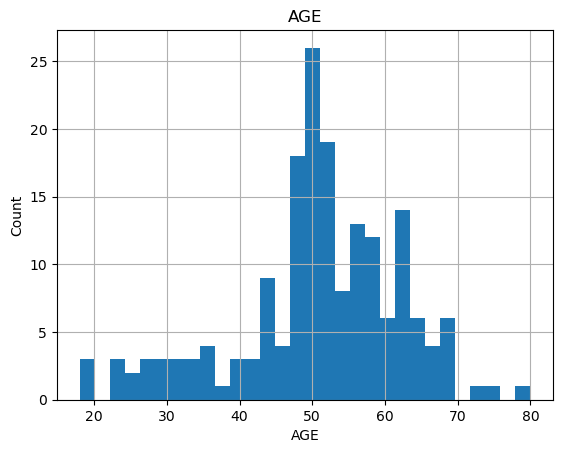

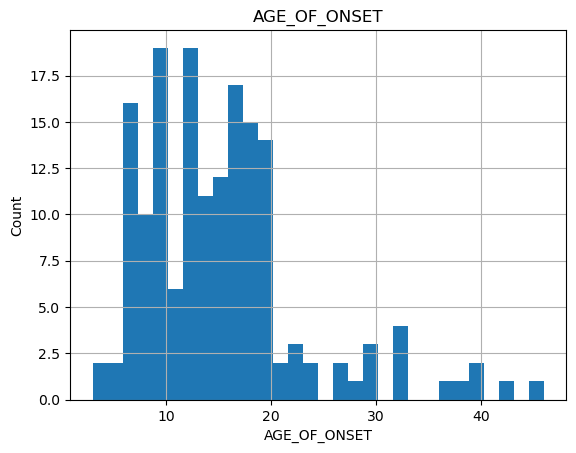

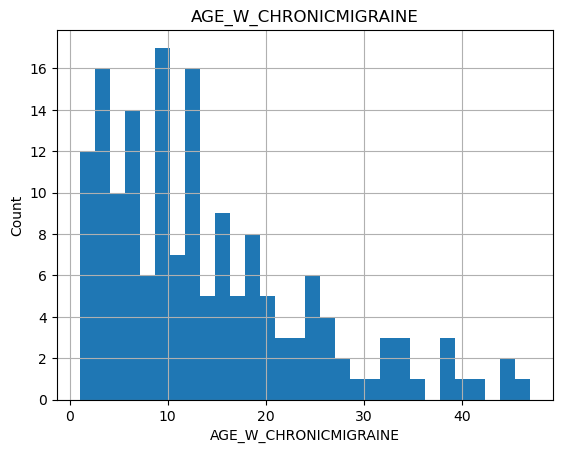

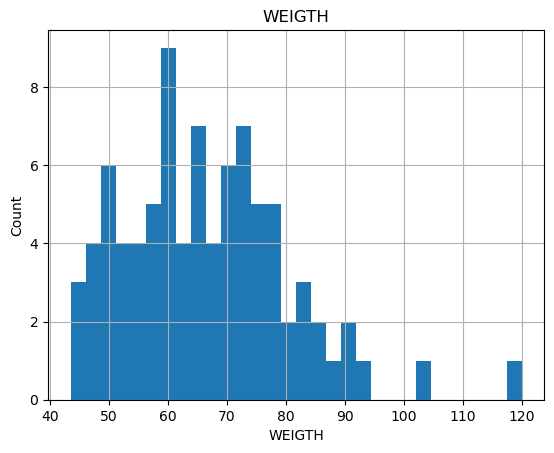

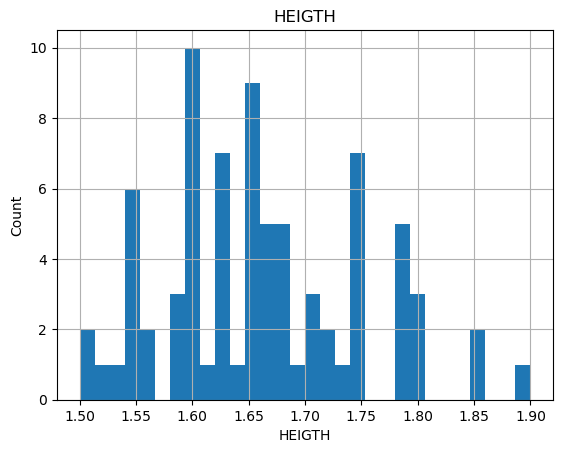

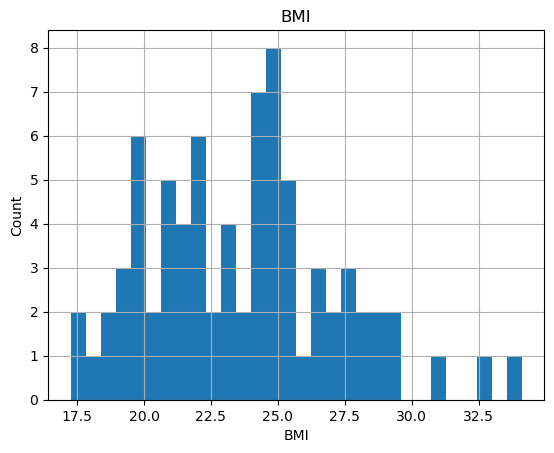

In [103]:
for col in continuous_vars:
    if df_baseline[col].nunique() > 2:
        plt.figure()
        df_baseline[col].dropna().hist(bins=30)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()


## missing values 


In [104]:
missing_pattern_baseline=missingness_matrix(df_baseline)
missing_pattern_longitudinal=missingness_matrix(df_longitudinal)

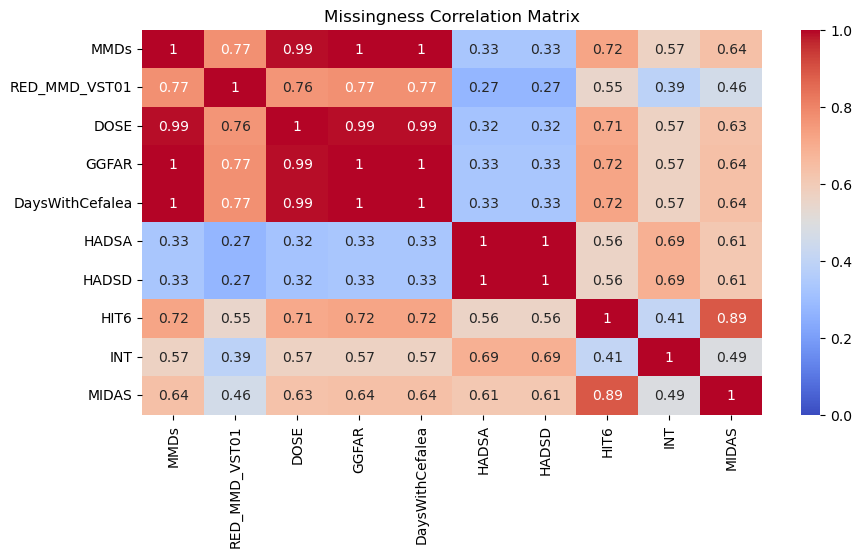

In [105]:
plt.figure(figsize=(10, 5))
sns.heatmap(missing_pattern_longitudinal,
            annot=True,
            cmap="coolwarm",
            vmin=0,
            vmax=1
    )
plt.title("Missingness Correlation Matrix")
plt.show()

The missingness correlation matrix reveals two dominant clusters of variables with near-perfect co-missingness, indicating that missingness is governed by shared latent mechanisms rather than random noise. The strong dependence between missingness indicators rejects the MCAR assumption. Furthermore, moderate correlations between missingness indicators and other observed clinical scales suggest that missingness is partially predictable from observed data, supporting the plausibility of a MAR mechanism.

In [106]:
df_baseline[df_baseline["AGE_W_CHRONICMIGRAINE"] == 47]

,SUBJECT_ID,AGE,SEX,DIAGNOSIS,Suspension,MONTHS_OF_TREAT,TREATMENT_DISC,AGE_OF_ONSET,AGE_W_CHRONICMIGRAINE,FAMILIARITY,...,Antiipnt,Pizotifene,Botulin,DETOXPRE,Psycopathological,Hypertension,Sleep_Disorders,PREV_T0,GGCEF_T0,INT_T0
91,92,63.0,1,1,1,3,INEFFICACIA,13.0,47.0,1.0,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,28,NaN


# longitudinal 


In [107]:
pre_stat(df_longitudinal)

,fraction_missing,count_missing,unique_value
SUBJECT_ID,0.000000,0,179
SEQUENCE,0.000000,0,15
CYCLE,0.000000,0,3
MONTH,0.000000,0,5
MMDs,0.400000,1074,32
RED_MMD_VST01,0.525512,1411,43
DOSE,0.402235,1080,88
GGFAR,0.398883,1071,32
DaysWithCefalea,0.398883,1071,32
HADSA,0.699069,1877,22


In [108]:
key = ["SUBJECT_ID", "CYCLE", "MONTH"]

dups = df_longitudinal[df_longitudinal.duplicated(key, keep=False)].sort_values(key)
print("Duplicate rows:", len(dups))
dups.head(10)

Duplicate rows: 0


,SUBJECT_ID,SEQUENCE,CYCLE,MONTH,MMDs,RED_MMD_VST01,DOSE,GGFAR,DaysWithCefalea,HADSA,HADSD,HIT6,INT,MIDAS


In [109]:
expected_cycles = {1, 2, 3}
expected_months = {1, 3, 6, 9, 12}

grid = (
    df_longitudinal.groupby("SUBJECT_ID")
      .apply(lambda x: pd.Series({
          "cycles_present": set(x["CYCLE"].dropna().astype(int)),
          "months_present": set(x["MONTH"].dropna().astype(int)),
          "n_rows": len(x)
      }))
      .reset_index()
)

grid["missing_cycles"] = grid["cycles_present"].apply(lambda s: expected_cycles - s)
grid["missing_months"] = grid["months_present"].apply(lambda s: expected_months - s)

grid.head()

C:\Users\aless\AppData\Local\Temp\ipykernel_10036\3274419517.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,SUBJECT_ID,cycles_present,months_present,n_rows,missing_cycles,missing_months
0,1,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}
1,2,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}
2,3,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}
3,4,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}
4,5,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}


In [110]:
bad_grid = grid[
    (grid["missing_cycles"].astype(str) != "set()") |
    (grid["missing_months"].astype(str) != "set()")
]

print("Subjects with incomplete grid:", len(bad_grid))
bad_grid.head(10)


Subjects with incomplete grid: 0


,SUBJECT_ID,cycles_present,months_present,n_rows,missing_cycles,missing_months


In [111]:
miss_by_time = (
    df_longitudinal
    .groupby(["CYCLE", "MONTH"])
    .agg(lambda x: x.isna().mean())
    .reset_index()
)

miss_by_time.loc[:, ["MMDs", "DOSE", "GGFAR", "HIT6", "INT", "MIDAS"]]

,MMDs,DOSE,GGFAR,HIT6,INT,MIDAS
0,0.000000,0.000000,0.000000,0.217877,0.217877,0.217877
1,0.000000,0.000000,0.000000,0.223464,0.525140,0.251397
2,0.100559,0.100559,0.100559,0.307263,0.536313,0.318436
3,0.223464,0.223464,0.223464,0.413408,0.553073,0.497207
4,0.262570,0.262570,0.262570,0.452514,0.575419,0.530726
5,0.547486,0.547486,0.547486,0.357542,0.530726,0.368715
6,0.480447,0.480447,0.480447,0.357542,0.681564,0.396648
7,0.508380,0.558659,0.508380,0.374302,0.698324,0.391061
8,0.558659,0.558659,0.558659,0.391061,0.737430,0.491620
9,0.508380,0.491620,0.491620,0.391061,0.737430,0.474860


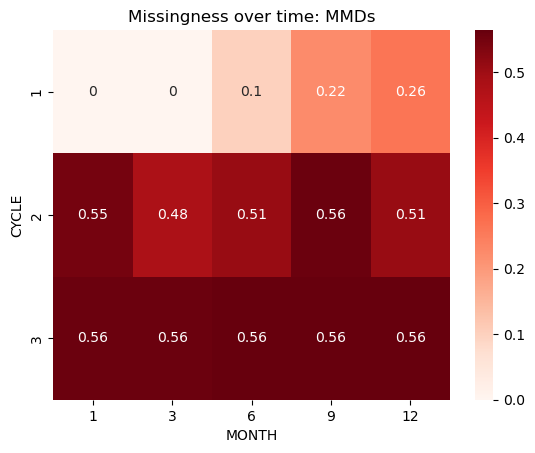

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    miss_by_time.pivot(index="CYCLE", columns="MONTH", values="MMDs"),
    cmap="Reds", annot=True
)
plt.title("Missingness over time: MMDs")
plt.show()


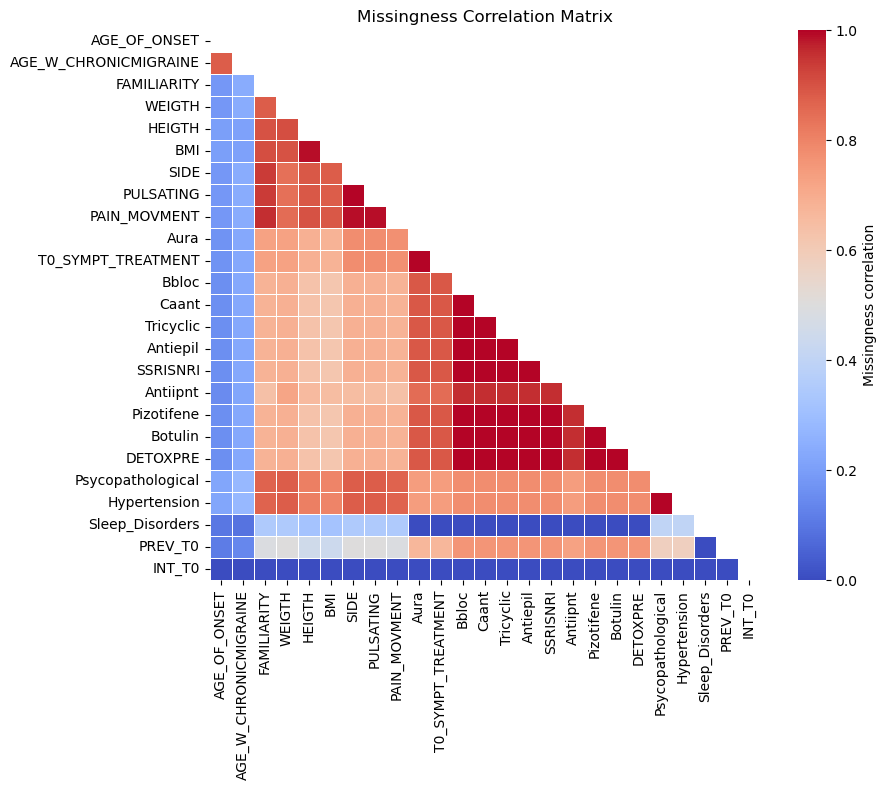

In [113]:
import numpy as np

mask = np.triu(np.ones_like(missing_pattern_baseline, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    missing_pattern_baseline,
    mask=mask,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Missingness correlation"}
)
plt.title("Missingness Correlation Matrix")
plt.tight_layout()
plt.show()

In [114]:
df_longitudinal[df_longitudinal["SUBJECT_ID"]== 1]


,SUBJECT_ID,SEQUENCE,CYCLE,MONTH,MMDs,RED_MMD_VST01,DOSE,GGFAR,DaysWithCefalea,HADSA,HADSD,HIT6,INT,MIDAS
0,1,1,1,1,13.0,NaN,15.0,13.0,13.0,3.0,5.0,63.0,6.0,63.0
179,1,2,1,3,1.0,12.0,12.0,10.0,10.0,5.0,2.0,61.0,6.0,120.0
358,1,3,1,6,3.0,10.0,2.0,2.0,3.0,5.0,2.0,48.0,5.0,4.0
537,1,4,1,9,4.0,9.0,6.0,4.0,4.0,5.0,5.0,48.0,4.0,6.0
716,1,5,1,12,1.0,12.0,13.0,10.0,10.0,9.0,8.0,0.0,6.0,4.0
895,1,6,2,1,26.0,NaN,31.0,26.0,26.0,6.0,6.0,66.0,5.0,114.0
1074,1,7,2,3,5.0,8.0,5.0,5.0,5.0,6.0,6.0,54.0,5.0,17.0
1253,1,8,2,6,8.0,5.0,8.0,8.0,8.0,6.0,6.0,54.0,0.0,17.0
1432,1,9,2,9,8.0,5.0,8.0,8.0,8.0,6.0,6.0,54.0,0.0,17.0
1611,1,10,2,12,8.0,5.0,8.0,8.0,8.0,6.0,6.0,54.0,0.0,17.0


In [115]:
issues = numerical_check(
    df_longitudinal,
    exclude={"SUBJECT_ID", "SEQUENCE", "CYCLE", "MONTH", "R_block"}
)

context_cols = ["SUBJECT_ID", "CYCLE", "MONTH"]

for col, info in issues.items():
    idx = info["extreme_values"].index

    cols_to_show = [c for c in context_cols if c in df_longitudinal.columns]
    if col not in cols_to_show:
        cols_to_show.append(col)

    print(f"\n=== {col} ===")
    print(
        df_longitudinal.loc[idx, cols_to_show]
        .sort_values(by=["SUBJECT_ID", "CYCLE", "MONTH"])
        .to_string(index=False)
    )



=== MMDs ===
 SUBJECT_ID  CYCLE  MONTH  MMDs
         27      3      1  31.0

=== RED_MMD_VST01 ===
 SUBJECT_ID  CYCLE  MONTH  RED_MMD_VST01
         29      1      6           29.0
         53      1      9           -6.0
         59      2     12           30.0
         59      3      6           29.0
         59      3      9           29.0
         59      3     12           29.0
         69      3      9           29.0
         69      3     12           30.0
        119      1      3           -6.0
        128      1      3           -8.0
        128      1      6           -7.0
        134      2     12          -16.0
        140      1      3          -10.0
        150      1      6           30.0
        151      2     12           29.0
        164      1     12           -6.0
        167      2     12           -6.0
        182      1      3          -12.0
        182      2     12          -18.0

=== DOSE ===
 SUBJECT_ID  CYCLE  MONTH  DOSE
         47      1      1 170.0
 

In [116]:
# baseline row (adjust if needed)
baseline = (
    df_longitudinal
    .query("CYCLE == 1 and MONTH == 1")
    .loc[:, ["SUBJECT_ID", "MMDs"]]
    .rename(columns={"MMDs": "MMDs_baseline"})
)

df_chk = df_longitudinal.merge(baseline, on="SUBJECT_ID", how="left")



df_chk["RED_calc_reversed"] = df_chk["MMDs_baseline"] - df_chk["MMDs"]
df_chk["RED_diff_rev"] = df_chk["RED_MMD_VST01"] - df_chk["RED_calc_reversed"]

mask = (
    df_chk["RED_MMD_VST01"].notna() &
    df_chk["MMDs"].notna() &
    df_chk["MMDs_baseline"].notna()
)

tol = 1e-6
bad_rev = df_chk[mask & (df_chk["RED_diff_rev"].abs() > tol)]

print("Inconsistencies if RED = baseline - current:", len(bad_rev))
bad_rev[["SUBJECT_ID","CYCLE","MONTH","MMDs_baseline","MMDs","RED_MMD_VST01","RED_calc_reversed","RED_diff_rev"]].head(20)


Inconsistencies if RED = baseline - current: 0


,SUBJECT_ID,CYCLE,MONTH,MMDs_baseline,MMDs,RED_MMD_VST01,RED_calc_reversed,RED_diff_rev


In [117]:

num_summary = df_longitudinal.describe().T
num_summary

,count,mean,std,min,25%,50%,75%,max
SUBJECT_ID,2685.0,91.111732,53.274926,1.0,45.0,90.0,136.0,187.0
SEQUENCE,2685.0,8.000000,4.321299,1.0,4.0,8.0,12.0,15.0
CYCLE,2685.0,2.000000,0.816649,1.0,1.0,2.0,3.0,3.0
MONTH,2685.0,6.200000,3.970626,1.0,3.0,6.0,9.0,12.0
MMDs,1611.0,12.249534,8.682591,0.0,6.0,10.0,18.0,31.0
RED_MMD_VST01,1274.0,12.954474,7.729894,-18.0,8.0,13.0,19.0,30.0
DOSE,1605.0,15.717134,20.245802,0.0,5.0,10.0,18.0,180.0
GGFAR,1614.0,10.776952,8.233485,0.0,5.0,8.0,15.0,31.0
DaysWithCefalea,1614.0,13.589839,8.888037,0.0,6.0,11.0,20.0,31.0
HADSA,808.0,5.220297,5.455553,0.0,2.0,4.0,7.0,80.0


In [118]:
invalid_hit6 = (df_longitudinal["HIT6"] < 36) | (df_longitudinal["HIT6"] > 78)
df_longitudinal.loc[invalid_hit6, "HIT6"] = np.nan

df_longitudinal.loc[df_longitudinal["HADSA"] > 21, "HADSA"] = np.nan
df_longitudinal.loc[(df_longitudinal["INT"] < 1) | (df_longitudinal["INT"] > 10), "INT"] = np.nan
df_longitudinal[df_longitudinal['INT'].isna()]

,SUBJECT_ID,SEQUENCE,CYCLE,MONTH,MMDs,RED_MMD_VST01,DOSE,GGFAR,DaysWithCefalea,HADSA,HADSD,HIT6,INT,MIDAS
78,79,1,1,1,28.0,NaN,17.0,13.0,28.0,NaN,NaN,NaN,NaN,NaN
79,80,1,1,1,27.0,NaN,35.0,27.0,28.0,NaN,NaN,NaN,NaN,NaN
80,81,1,1,1,28.0,NaN,20.0,15.0,28.0,NaN,NaN,NaN,NaN,NaN
81,82,1,1,1,28.0,NaN,35.0,28.0,28.0,NaN,NaN,NaN,NaN,NaN
82,83,1,1,1,25.0,NaN,0.0,0.0,28.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,183,15,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2681,184,15,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2682,185,15,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2683,186,15,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
df_longitudinal.to_csv(DATA_DIR /'cleaned'/ "df_longitudinal_clean.csv",
    index=False
)

# boh

In [120]:
sum(df_baseline['Suspension']==1)

101

In [121]:
df_longitudinal[df_longitudinal['SUBJECT_ID']== 160]

,SUBJECT_ID,SEQUENCE,CYCLE,MONTH,MMDs,RED_MMD_VST01,DOSE,GGFAR,DaysWithCefalea,HADSA,HADSD,HIT6,INT,MIDAS
155,160,1,1,1,28.0,NaN,28.0,28.0,28.0,NaN,NaN,71.0,8.0,50.0
334,160,2,1,3,28.0,0.0,28.0,28.0,28.0,NaN,NaN,67.0,NaN,25.0
513,160,3,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692,160,4,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
871,160,5,1,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1050,160,6,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1229,160,7,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1408,160,8,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1587,160,9,2,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1766,160,10,2,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
import numpy as np
import pandas as pd

# --- 1) Take only rows where we actually observed the core outcome (MMDs) ---
obs = df_longitudinal.loc[df_longitudinal["MMDs"].notna(),
                          ["SUBJECT_ID", "CYCLE", "MONTH", "SEQUENCE", "MMDs"]].copy()

# --- 2) For each subject: get the last observed (CYCLE, MONTH)
# Sort so the last row per subject is the last timepoint
obs = obs.sort_values(["SUBJECT_ID", "CYCLE", "MONTH"])

last_visit = (
    obs.groupby("SUBJECT_ID", as_index=False)
       .tail(1)
       .loc[:, ["SUBJECT_ID", "CYCLE", "MONTH", "SEQUENCE"]]
       .rename(columns={"CYCLE": "last_cycle", "MONTH": "last_month", "SEQUENCE": "last_sequence"})
)

# --- 3) Classify dropout status relative to intended completion (Cycle 3, Month 12) ---
last_visit["dropout_status"] = np.select(
    [
        (last_visit["last_cycle"] == 3) & (last_visit["last_month"] == 12),
        (last_visit["last_cycle"] == 1),
        (last_visit["last_cycle"] == 2),
        (last_visit["last_cycle"] == 3) & (last_visit["last_month"] < 12),
    ],
    [
        "Completed",
        "Dropped after Cycle 1",
        "Dropped after Cycle 2",
        "Dropped during Cycle 3",
    ],
    default="Unknown"
)

# --- 4) Summary counts ---
status_counts = last_visit["dropout_status"].value_counts()
print(status_counts)

# If you want proportions:
print((status_counts / status_counts.sum()).round(3))

# --- 5) (Optional) Inspect who dropped out early ---
last_visit.sort_values(["last_cycle", "last_month"]).head(10)


dropout_status
Completed                 78
Dropped after Cycle 1     75
Dropped after Cycle 2     25
Dropped during Cycle 3     1
Name: count, dtype: int64
dropout_status
Completed                 0.436
Dropped after Cycle 1     0.419
Dropped after Cycle 2     0.140
Dropped during Cycle 3    0.006
Name: count, dtype: float64


,SUBJECT_ID,last_cycle,last_month,last_sequence,dropout_status
270,92,1,3,2,Dropped after Cycle 1
285,107,1,3,2,Dropped after Cycle 1
297,119,1,3,2,Dropped after Cycle 1
309,132,1,3,2,Dropped after Cycle 1
311,134,1,3,2,Dropped after Cycle 1
322,146,1,3,2,Dropped after Cycle 1
323,148,1,3,2,Dropped after Cycle 1
333,158,1,3,2,Dropped after Cycle 1
334,160,1,3,2,Dropped after Cycle 1
335,161,1,3,2,Dropped after Cycle 1


In [123]:
df_baseline[df_baseline['SUBJECT_ID']== 107]

,SUBJECT_ID,AGE,SEX,DIAGNOSIS,Suspension,MONTHS_OF_TREAT,TREATMENT_DISC,AGE_OF_ONSET,AGE_W_CHRONICMIGRAINE,FAMILIARITY,...,Antiipnt,Pizotifene,Botulin,DETOXPRE,Psycopathological,Hypertension,Sleep_Disorders,PREV_T0,GGCEF_T0,INT_T0
106,107,51.0,1,2,1,5,DROP-OUT,18.0,13.0,0.0,...,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,28,NaN


In [124]:

dropouts = last_visit.loc[
    last_visit["dropout_status"] != "Completed"
].copy()

dropouts
dropouts = dropouts.merge(
    df_baseline,
    on="SUBJECT_ID",
    how="left",
    suffixes=("", "_baseline")
)

In [125]:
dropouts[dropouts['TREATMENT_DISC']=='COMPLETED']

,SUBJECT_ID,last_cycle,last_month,last_sequence,dropout_status,AGE,SEX,DIAGNOSIS,Suspension,MONTHS_OF_TREAT,...,Antiipnt,Pizotifene,Botulin,DETOXPRE,Psycopathological,Hypertension,Sleep_Disorders,PREV_T0,GGCEF_T0,INT_T0
0,36,3,3,12,Dropped during Cycle 3,60.0,1,2,0,36,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,22,8.0


In [126]:
df_longitudinal[df_longitudinal['SUBJECT_ID']== 36]

,SUBJECT_ID,SEQUENCE,CYCLE,MONTH,MMDs,RED_MMD_VST01,DOSE,GGFAR,DaysWithCefalea,HADSA,HADSD,HIT6,INT,MIDAS
35,36,1,1,1,22.0,NaN,25.0,22.0,22.0,9.0,6.0,72.0,8.0,49.0
214,36,2,1,3,2.0,20.0,19.0,12.0,20.0,11.0,13.0,68.0,6.0,89.0
393,36,3,1,6,2.0,20.0,0.0,0.0,7.0,5.0,5.0,61.0,5.0,62.0
572,36,4,1,9,8.0,14.0,8.0,8.0,8.0,6.0,6.0,59.0,7.0,32.0
751,36,5,1,12,5.0,17.0,5.0,5.0,10.0,4.0,1.0,NaN,3.0,4.0
930,36,6,2,1,17.0,NaN,19.0,17.0,17.0,3.0,5.0,67.0,6.0,53.0
1109,36,7,2,3,12.0,10.0,8.0,8.0,12.0,5.0,6.0,61.0,4.0,25.0
1288,36,8,2,6,8.0,14.0,8.0,8.0,8.0,5.0,5.0,56.0,6.0,12.0
1467,36,9,2,9,13.0,9.0,13.0,13.0,13.0,1.0,5.0,53.0,6.0,9.0
1646,36,10,2,12,13.0,9.0,13.0,13.0,13.0,1.0,5.0,50.0,6.0,7.0


In [127]:
def add_in_window(
    df_long: pd.DataFrame,
    df_base: pd.DataFrame,
    id_col: str = "SUBJECT_ID",
    cycle_col: str = "CYCLE",
    month_col: str = "MONTH",
    suspension_col: str = "Suspension",        # 0=completed, 1=discontinued
    months_treat_col: str = "MONTHS_OF_TREAT",  # months on treatment
) -> pd.DataFrame:
    """
    Add dropout-aware follow-up eligibility indicator `in_window` to longitudinal data.

    Rule:
      - If Suspension == 0 (completed): in_window = True for all scheduled rows
      - If Suspension == 1 (discontinued): in_window = (t_abs <= MONTHS_OF_TREAT)
      - If Suspension missing/unknown: in_window = True (conservative default)

    Also adds `t_abs = 12*(CYCLE-1)+MONTH`.
    """
    # --- Basic checks
    for c in [id_col, cycle_col, month_col]:
        if c not in df_long.columns:
            raise ValueError(f"df_long missing required column: {c}")
    for c in [id_col, suspension_col, months_treat_col]:
        if c not in df_base.columns:
            raise ValueError(f"df_base missing required column: {c}")

    # --- Ensure numeric types (robust to strings)
    out = df_long.copy()
    out[id_col] = pd.to_numeric(out[id_col], errors="coerce").astype("Int64")
    out[cycle_col] = pd.to_numeric(out[cycle_col], errors="coerce")
    out[month_col] = pd.to_numeric(out[month_col], errors="coerce")

    base = df_base.copy()
    base[id_col] = pd.to_numeric(base[id_col], errors="coerce").astype("Int64")
    base[suspension_col] = pd.to_numeric(base[suspension_col], errors="coerce")
    base[months_treat_col] = pd.to_numeric(base[months_treat_col], errors="coerce")

    # --- Merge baseline fields onto longitudinal
    cols_needed = [id_col, suspension_col, months_treat_col]
    base = base[cols_needed].drop_duplicates(subset=[id_col])

    out = out.merge(base, on=id_col, how="left")

    # --- Absolute treatment-time index (1..36 if MONTH in {1,3,6,9,12})
    out["t_abs"] = 12 * (out[cycle_col] - 1) + out[month_col]

    # --- Dropout-aware in_window
    # Completed => True
    # Discontinued => t_abs <= months treated
    # Unknown => True (conservative)
    out["in_window"] = np.where(
        out[suspension_col].eq(0),
        True,
        np.where(
            out[suspension_col].eq(1),
            out[months_treat_col].notna() & (out["t_abs"] <= out[months_treat_col]),
            True
        )
    )

    # Cast to boolean dtype
    out["in_window"] = out["in_window"].astype(bool)

    return out


# -----------------------------


df_long = add_in_window(df_longitudinal, df_baseline)

# Create dropout-safe dataset (equivalent to df_long_work in R)
df_long_work = df_long[df_long["in_window"]].copy()

print(df_long[["SUBJECT_ID", "CYCLE", "MONTH", "t_abs", "Suspension", "MONTHS_OF_TREAT", "in_window"]].head(10))
print("Rows in-window:", df_long_work.shape[0], " / total:", df_long.shape[0])


   SUBJECT_ID  CYCLE  MONTH  t_abs  Suspension  MONTHS_OF_TREAT  in_window
0           1      1      1      1           0               36       True
1           2      1      1      1           0               36       True
2           3      1      1      1           0               36       True
3           4      1      1      1           0               36       True
4           5      1      1      1           0               36       True
5           6      1      1      1           0               36       True
6           7      1      1      1           0               36       True
7           8      1      1      1           0               36       True
8           9      1      1      1           0               36       True
9          10      1      1      1           0               36       True
Rows in-window: 1751  / total: 2685


In [128]:

df_in = df_long[df_long["in_window"] == True]
total_missing_not_lfu = df_in.isna().sum().sum()
print("Total missing values (not due to LFU):", int(total_missing_not_lfu))

# ----------------------------
# 2) Missing values per variable (not due to LFU)
# ----------------------------
missing_by_var = (
    df_in.isna()
        .sum()
        .sort_values(ascending=False)
        .rename("n_missing")
        .reset_index()
        .rename(columns={"index": "variable"})
)
print("\nMissing by variable (not due to LFU):")
print(missing_by_var)

# ----------------------------
# 3) Missing values per subject (not due to LFU)
# ----------------------------
missing_by_subject = (
    df_in.groupby("SUBJECT_ID")
        .apply(lambda g: g.isna().sum().sum())
        .rename("n_missing")
        .sort_values(ascending=False)
        .reset_index()
)
print("\nMissing by subject (not due to LFU) — top 20:")
print(missing_by_subject.head(20))

# ----------------------------
# 4) Missing MMDs per cycle × month (not due to LFU)
# ----------------------------
missing_mmds_by_time = (
    df_in.groupby(["CYCLE", "MONTH"])["MMDs"]
        .apply(lambda s: s.isna().sum())
        .rename("n_missing_MMDs")
        .reset_index()
        .sort_values(["CYCLE", "MONTH"])
)
print("\nMissing MMDs by (CYCLE, MONTH) (not due to LFU):")
print(missing_mmds_by_time)

# ----------------------------
# 5) Optional diagnostic: how many missing cells are in post-LFU rows?
# ----------------------------
df_post = df_long[df_long["in_window"] == False]
post_lfu_total_cells = df_post.shape[0] * df_post.shape[1]
post_lfu_missing_cells = df_post.isna().sum().sum()
print("\nPost-LFU rows: total cells =", post_lfu_total_cells,
      "| missing cells =", int(post_lfu_missing_cells))


Total missing values (not due to LFU): 4670

Missing by variable (not due to LFU):
           variable  n_missing
0             HADSA       1012
1             HADSD       1010
2               INT        804
3     RED_MMD_VST01        490
4             MIDAS        398
5              HIT6        347
6              DOSE        159
7              MMDs        150
8             GGFAR        150
9   DaysWithCefalea        150
10            t_abs          0
11  MONTHS_OF_TREAT          0
12       Suspension          0
13       SUBJECT_ID          0
14         SEQUENCE          0
15            MONTH          0
16            CYCLE          0
17        in_window          0

Missing by subject (not due to LFU) — top 20:
    SUBJECT_ID  n_missing
0          185        100
1          124         83
2          105         71
3           89         67
4           80         61
5           91         60
6           84         60
7           66         55
8           51         55
9          123       

C:\Users\aless\AppData\Local\Temp\ipykernel_10036\1274066682.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.isna().sum().sum())


In [129]:
# 1) Define the continuous variables based on your clinical measures
# These were identified in your previous R script
cont_vars = ["MMDs", "DOSE", "GGFAR", "HADSA", "HADSD", "HIT6", "INT", "MIDAS"]

# Filter for only those columns that actually exist in your dataframe
available_vars = [v for v in cont_vars if v in df_long.columns]

# 2) Filter for "In-Window" data only (df_in)
df_in = df_long[df_long["in_window"] == True].copy()


# Total missingness proportion within the window
total_cells = df_in[available_vars].size
total_missing = df_in[available_vars].isna().sum().sum()
pct_total_missing = (total_missing / total_cells) * 100

# Variable-level summary
missing_summary = pd.DataFrame({
    'n_missing': df_in[available_vars].isna().sum(),
    'pct_missing': (df_in[available_vars].isna().sum() / len(df_in)) * 100
}).sort_values('pct_missing', ascending=False)

print(f"--- Global Diagnostic: In-Window Data ---")
print(f"Total Missingness Rate: {pct_total_missing:.2f}%")
print("\n--- Missingness by Variable ---")
print(missing_summary)

# 5) Identify "High-Attrition" Subjects
# Subjects who have > 50% missing data in-window across all outcomes
subj_missing = df_in.groupby("SUBJECT_ID")[available_vars].apply(lambda x: x.isna().mean().mean())
high_missing_subjects = subj_missing[subj_missing > 0.5]

print("\n--- Subjects with >50% In-Window Missingness ---")
print(high_missing_subjects)

--- Global Diagnostic: In-Window Data ---
Total Missingness Rate: 28.77%

--- Missingness by Variable ---
       n_missing  pct_missing
HADSA       1012    57.795545
HADSD       1010    57.681325
INT          804    45.916619
MIDAS        398    22.729869
HIT6         347    19.817247
DOSE         159     9.080525
MMDs         150     8.566533
GGFAR        150     8.566533

--- Subjects with >50% In-Window Missingness ---
SUBJECT_ID
79     0.531250
80     0.568182
82     0.531250
83     0.531250
84     0.556818
85     0.541667
86     0.546875
87     0.517857
88     0.546875
89     0.583333
90     0.569444
91     0.556818
92     0.562500
93     0.531250
95     0.520833
96     0.531250
97     0.520833
98     0.520833
100    0.541667
101    0.517857
103    0.511364
104    0.517857
105    0.557692
106    0.517857
107    0.562500
114    0.525000
115    0.562500
117    0.550000
123    0.638889
124    0.772727
125    0.535714
132    0.541667
133    0.625000
136    0.553571
137    0.535714
139